In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter15-RNR"
unique_name = "BERT_Finetuned_GCN"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Twitter15-RNR_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(1490, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15_dataset_with_tvt.csv", lineterminator="\n")
data.head()

tweet_id                                         tweet_text  \
0  731166399389962242  🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...   
1  714598641827246081  an open letter to trump voters from his top st...   
2  691809004356501505  america is a nation of second chances —@potus ...   
3  693204708933160960  brandon marshall visits and offers advice, sup...   
4  551099691702956032  rip elly may clampett: so sad to learn #beverl...   

        label       tvt  cv_fold        tt        tvt2  
0  unverified  training        1  training    training  
1  unverified  training        1      test    training  
2   non-rumor  training        2  training  validation  
3   non-rumor  training        1  training    testting  
4        true  training        3  training  validation

In [4]:
labels_str = ["rumours", "non-rumours"]
labels_str

['rumours', 'non-rumours']

In [5]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] in ['true', 'false', 'unverified']:
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [6]:
train_mask = np.array([True if d['tvt2'] == 'training' else False for i, d in data.iterrows()])
val_mask = np.array([True if d['tvt2'] == 'validation' else False for i, d in data.iterrows()])
test_mask = np.array([True if d['tvt2'] == 'testting' else False for i, d in data.iterrows()])

edge_index_training = [[], []]
edge_index_testing = [[], []]

In [7]:
print(train_mask.shape)
print(val_mask.shape)
print(test_mask.shape)

print(np.unique(train_mask, return_counts=True))
print(np.unique(val_mask, return_counts=True))
print(np.unique(test_mask, return_counts=True))

(1490,)
(1490,)
(1490,)
(array([False,  True]), array([ 466, 1024]))
(array([False,  True]), array([1152,  338]))
(array([False,  True]), array([1362,  128]))


In [8]:
texts = data['tweet_text'].tolist()
links = []
for text in texts:
    temp = []
    tokens = text.split()
    for token in tokens:
        if "#" in token:
            temp.append(token)
    links.append(temp)
    
for i, t1 in enumerate(links):
    for j, t2 in enumerate(links):
        if i == j:
            continue

        for t in t1:
            if t in t2:
                edge_index_testing[0].append(i)
                edge_index_testing[1].append(j)
                
                if not test_mask[i] and not test_mask[j]:
                    edge_index_training[0].append(i)
                    edge_index_training[1].append(j)
                    
#                 break
    
# for i, t1 in enumerate(links):
#     for j, t2 in enumerate(links[i+1:]):
#         for t in t1:
#             if t in t2:
#                 edge_index_testing[0].append(i)
#                 edge_index_testing[1].append(i + j + 1)
                
#                 if not test_mask[i] and not test_mask[j]:
#                     edge_index_training[0].append(i)
#                     edge_index_training[1].append(i + j + 1)
                    
#                 break

In [9]:
print(len(edge_index_training[0]))
print(len(edge_index_testing[0]))

5568
6464


In [10]:
import time
import os
from typing import Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import matplotlib.pyplot as plt
import networkx as nx

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, device):
        super(GCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels).to(device)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j
    

class Net(nn.Module):
    def __init__(self, n_input, n_output, device):
        super(Net, self).__init__()
        self.gcn_conv1 = GCNConv(n_input, 128, device)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.gcn_conv2 = GCNConv(128, n_output, device)
    
    def forward(self, dataset):
        x = self.gcn_conv1(dataset.x, dataset.edge_index)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.gcn_conv2(x, dataset.edge_index)
        
        return F.log_softmax(x, dim=1)


class NNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.criterion = criterion()
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = Net(n_input, n_output, self.device)
        self.model = self.model.to(device)
#         if self.device == 'cuda':
#             self.model = torch.nn.DataParallel(self.model)
#             cudnn.benchmark = True

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

    def forward(self, dataset):
        return self.model(dataset)
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def train_eval(self,
        dataset: torch_geometric.data.data.Data,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        dataset = dataset.to(self.device)

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        best_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            self.model.zero_grad()
            outputs = self.model(dataset)

            targets = dataset.y[dataset.train_mask]
            loss = self.criterion(outputs[dataset.train_mask], targets)

            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            total += targets.size(0)
                
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                outputs = self.model(dataset)
                loss = self.criterion(outputs[dataset.val_mask], dataset.y[dataset.val_mask])

                test_loss += loss.item()
                
                preds = self.model(dataset).max(dim=1)[1]
                preds = preds[dataset.val_mask]
                test_labels = dataset.y[dataset.val_mask]
                conf_mat = ConfusionMatrix(
                    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
                    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    binary=False
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}, at epoch {epoch}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 29.586, at epoch 1
Saving after new best accuracy : 86.686, at epoch 2
Saving after new best accuracy : 86.982, at epoch 3
-- Epoch 5, Train Loss : 0.3328915536403656, Test Loss : 0.423576682806015
-- Epoch 10, Train Loss : 0.14144805073738098, Test Loss : 0.3666442334651947
-- Epoch 15, Train Loss : 0.0761433020234108, Test Loss : 0.37980329990386963
-- Epoch 20, Train Loss : 0.04641734063625336, Test Loss : 0.40773990750312805
-- Epoch 25, Train Loss : 0.03216715529561043, Test Loss : 0.436789333820343
-- Epoch 30, Train Loss : 0.024021001532673836, Test Loss : 0.46418699622154236
-- Epoch 35, Train Loss : 0.019247720018029213, Test Loss : 0.489667683839798
-- Epoch 40, Train Loss : 0.015361707657575607, Test Loss : 0.5124453902244568
-- Epoch 45, Train Loss : 0.013105692341923714, Test Loss : 0.5335975885391235
-- Epoch 50, Train Loss : 0.011421017348766327, Test Loss : 0.5531091094017

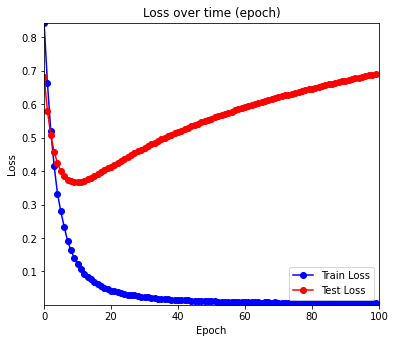

Exec Time : 5.38 seconds


In [11]:
print("Multiclass Classification using 4-Layer Linear Network")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

start = time.time()
model_name = f"{dataset_name}_4LayerNet_{unique_name}"
model = NNClassifier(vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
dataset = torch_geometric.data.data.Data(
            x=torch.Tensor(vectors).to(device),
            y=torch.Tensor(labels).long().to(device),
            edge_index=torch.Tensor(edge_index_training).long().to(device),
            train_mask=torch.Tensor(train_mask).bool().to(device),
            val_mask=torch.Tensor(val_mask).bool().to(device),
            test_mask=torch.Tensor(test_mask).bool().to(device)
        )
model.train_eval(dataset,
                saves=model_name,
                n_iter=100,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

In [12]:
print("\nValidation Set")
preds = model.model(dataset).max(dim=1)[1]
print(f"Predictions : {preds.shape}")

preds = preds[dataset.val_mask]
preds = preds.cpu().numpy()
val_labels = dataset.y[dataset.val_mask]

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\nTest Set")
dataset.edge_index = torch.Tensor(edge_index_testing).long().to(device)
preds = model.model(dataset).max(dim=1)[1]
print(f"Predictions : {preds.shape}")

preds = preds[dataset.test_mask]
preds = preds.cpu().numpy()
test_labels = dataset.y[dataset.test_mask]

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)


Validation Set
Predictions : torch.Size([1490])
338 vs 338
Multi Class Evaluation

Class rumours Evaluation
- Precision : 86.957 %
- Recall : 96.774 %
- F1 : 0.91603

Class non-rumours Evaluation
- Precision : 87.097 %
- Recall : 60.0 %
- F1 : 0.71053

Combined Evaluation
- Accuracy : 86.982 %
- Precision : 87.027 %
- Recall : 78.387 %
- F1 : 0.82481

- Average Confidence : 100.0 %
Model, Combined,,,,rumours,,,non-rumours,,,
Twitter15-RNR_4LayerNet_BERT_Finetuned_GCN Validation, 86.982, 87.027, 78.387, 0.82481, 86.957, 96.774, 0.91603, 87.097, 60.0, 0.71053, 

Test Set
Predictions : torch.Size([1490])
128 vs 128
Multi Class Evaluation

Class rumours Evaluation
- Precision : 92.157 %
- Recall : 96.907 %
- F1 : 0.94472

Class non-rumours Evaluation
- Precision : 88.462 %
- Recall : 74.194 %
- F1 : 0.80702

Combined Evaluation
- Accuracy : 91.406 %
- Precision : 90.309 %
- Recall : 85.55 %
- F1 : 0.87865

- Average Confidence : 100.0 %
Model, Combined,,,,rumours,,,non-rumours,,,
Twitter1